# АБ-тест по увеличению конверсии в показы и клики

**Задача:** проанализировать изменение метрик по странице лендинга после редизайна объявления.

**Вывод:** В тестовой группе конверсия выросла на 10% (или 1.47 п.п.), CTR на 11% (0.38 п.п.), а отношение кликов к пользователю на 12.8% (2.2 п.п.).

Во всех положительных изменениях была зафиксирована статистическая значимость, поэтому я рекомендую раскатывать новую версию объявления на всех пользователей.

### Имортируем библиотеки

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

### Проверим валидность данных

In [4]:
df = pd.read_csv('ab_test_results_aggregated_views_clicks_2.csv')

In [3]:
df

,user_id,group,views,clicks
0,1,control,10.0,0.0
1,2,control,1.0,0.0
2,3,control,1.0,0.0
3,4,control,2.0,0.0
4,5,control,3.0,0.0
...,...,...,...,...
119995,119996,test,9.0,0.0
119996,119997,test,2.0,1.0
119997,119998,test,20.0,1.0
119998,119999,test,6.0,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  120000 non-null  int64  
 1   group    120000 non-null  object 
 2   views    120000 non-null  float64
 3   clicks   120000 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.7+ MB


In [185]:
df[df.duplicated()]

,user_id,group,views,clicks


In [5]:
df.describe()

,user_id,views,clicks
count,120000.000000,120000.000000,120000.000000
mean,60000.500000,4.991075,0.182692
std,34641.160489,5.915200,0.472547
min,1.000000,1.000000,0.000000
25%,30000.750000,2.000000,0.000000
50%,60000.500000,3.000000,0.000000
75%,90000.250000,6.000000,0.000000
max,120000.000000,205.000000,9.000000


In [6]:
df['user_id'].nunique()

120000

In [7]:
df.groupby('group')['user_id'].agg(['count', 'nunique'])

,count,nunique
group,,
control,60000,60000
test,60000,60000


Отлично, в датасете нет ни дубликатов, ни пропущенных значений, ни пользователей попавших сразу в обе группы.

Изучим сводку:

In [8]:
df.groupby('group')[['views', 'clicks']].agg(['mean', 'median', 'std', 'min', 'max', 'sum'])

views                                           clicks         \
            mean median       std  min    max       sum      mean median   
group                                                                      
control  4.95240    3.0  5.781752  1.0  131.0  297144.0  0.171717    0.0   
test     5.02975    3.0  6.045503  1.0  205.0  301785.0  0.193667    0.0   

                                      
              std  min  max      sum  
group                                 
control  0.453799  0.0  7.0  10303.0  
test     0.490337  0.0  9.0  11620.0

Посмотрим еще, почему у столбцов views и clicks нецелочисленный тип данных, и есть ли там действительно не целые числа (а их быть не должно).

In [18]:
df[df['views'] * 10 % 10 != 0]

,user_id,group,views,clicks


In [17]:
df[df['clicks'] * 10 % 10 != 0]

,user_id,group,views,clicks


Все числа натуральные, тогда сразу приведем их к интам.

In [19]:
df['views'] = df['views'].astype('int64')
df['clicks'] = df['clicks'].astype('int64')

In [20]:
df.head(3)

,user_id,group,views,clicks
0,1,control,10,0
1,2,control,1,0
2,3,control,1,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  120000 non-null  int64 
 1   group    120000 non-null  object
 2   views    120000 non-null  int64 
 3   clicks   120000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3.7+ MB


Теперь посмотрим как распределены показы и клики в обеих группах на графике.

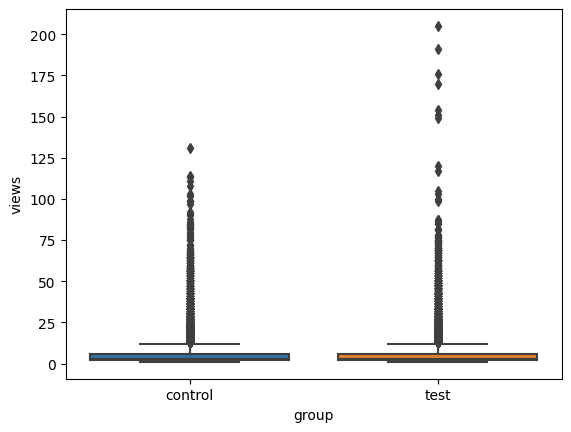

In [28]:
sns.boxplot(df, x='group', y='views');

Отсечем последний процентиль, чтобы стало поменьше выбросов.

In [29]:
df.groupby('group')[['views', 'clicks']].quantile(0.99)

,views,clicks
group,,
control,28.0,2.0
test,28.0,2.0


In [30]:
df2 = df[df['views'] < 29]

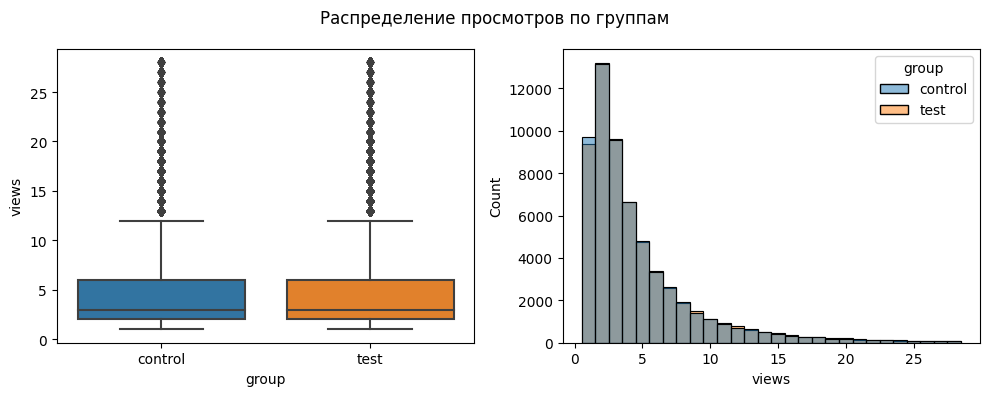

In [32]:
plt.figure(figsize=(10, 4), layout='tight')
plt.suptitle('Распределение просмотров по группам')

plt.subplot(1, 2, 1)
sns.boxplot(df2, x='group', y='views')

plt.subplot(1, 2, 2)
sns.histplot(df2, x='views', hue='group', discrete=True)

plt.show()

И посмотрим сводку без этих выбросов.

In [157]:
df2.groupby('group')[['views', 'clicks']] \
    .agg(['mean', 'median', 'std', 'min', 'max', 'sum', 'count'])

views                                            clicks         \
             mean median       std min max     sum  count      mean median   
group                                                                        
control  4.598698    3.0  4.237794   1  28  273342  59439  0.159373    0.0   
test     4.648790    3.0  4.272946   1  28  276166  59406  0.179763    0.0   

                                         
              std min max    sum  count  
group                                    
control  0.418161   0   5   9473  59439  
test     0.450258   0   5  10679  59406

Посмотрим на пользователей, которых мы выкинули.

In [161]:
outliers = df[~df['user_id'].isin(df2['user_id'])]
outliers

,user_id,group,views,clicks
19,20,control,31,2
193,194,control,31,0
196,197,control,64,1
227,228,control,30,1
322,323,control,37,2
...,...,...,...,...
119836,119837,test,33,2
119842,119843,test,31,0
119876,119877,test,49,1
119938,119939,test,51,0


In [165]:
outliers['clicks'].value_counts()

1    369
0    287
2    264
3    131
4     66
5     21
6     10
7      5
9      1
8      1
Name: clicks, dtype: int64

Думаю, что при расчете критериев я не буду выкидывать их из наблюдения. Они не выглядят аномально, 200 показов - вполне реальная цифра просмотра "call-to-action" реклам.

Теперь изучим клики, для наглядности я убрал все 0 на графиках, их очень много.

In [40]:
df['clicks'].value_counts(normalize=True).round(4)

0    0.8456
1    0.1320
2    0.0180
3    0.0031
4    0.0008
5    0.0002
6    0.0001
7    0.0000
9    0.0000
8    0.0000
Name: clicks, dtype: float64

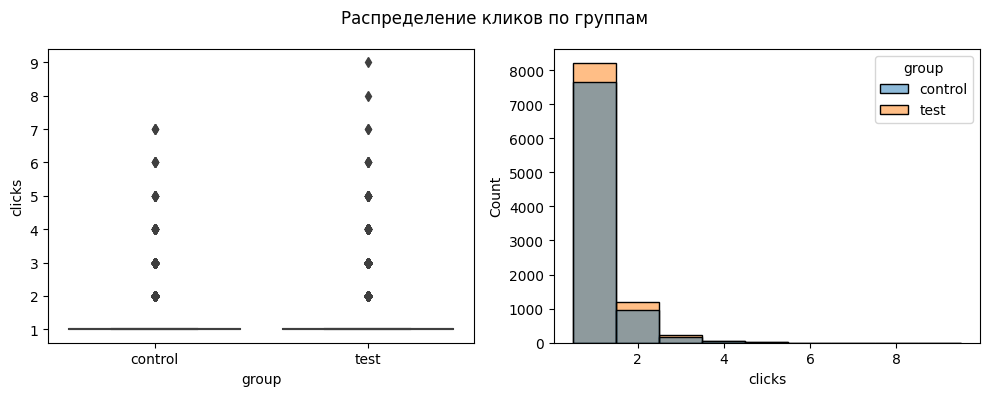

In [34]:
plt.figure(figsize=(10, 4), layout='tight')
plt.suptitle('Распределение кликов по группам')

plt.subplot(1, 2, 1)
sns.boxplot(df[df['clicks'] != 0], x='group', y='clicks')

plt.subplot(1, 2, 2)
sns.histplot(df[df['clicks'] != 0], x='clicks', hue='group', discrete=True)

plt.show()

### Проверка гипотез

Я выделил 3 основные метрики для сравнения:

1) отношение кликов к просмотрам CTR (прокси-метрика)

2) отношение кликов к пользователям (прокси-метрика)

3) конверсия в клик (целевая метрика)

Нам нужно поймать эффект в Конверсии в клик, при этом убедившись что остальные две метрики-отношения не просели.

In [53]:
total_clicks_control = df[df['group'] == 'control']['clicks'].sum()
total_clicks_test = df[df['group'] == 'test']['clicks'].sum()

total_views_control = df[df['group'] == 'control']['views'].sum()
total_views_test = df[df['group'] == 'test']['views'].sum()

cr_clicks_per_view_control = total_clicks_control / total_views_control
cr_clicks_per_view_test = total_clicks_test / total_views_test

print(f'CTR in control group: {round(cr_clicks_per_view_control * 100, 2)} %',
      f'CTR in test group: {round(cr_clicks_per_view_test * 100, 2)} %', sep='\n')

CTR in control group: 3.47 %
CTR in test group: 3.85 %


In [63]:
total_users_control = df[df['group'] == 'control']['user_id'].nunique()
total_users_test = df[df['group'] == 'test']['user_id'].nunique()

cr_clicks_per_user_control = total_clicks_control / total_users_control
cr_clicks_per_user_test = total_clicks_test / total_users_test

print(f'Clicks per user in control group: {round(cr_clicks_per_user_control * 100, 2)} %',
      f'Clicks per user in test group: {round(cr_clicks_per_user_test * 100, 2)} %', sep='\n')

Clicks per user in control group: 17.17 %
Clicks per user in test group: 19.37 %


In [52]:
total_converted_users_control = len(df[(df['group'] == 'control') & (df['clicks'] > 0)])
total_converted_users_test = len(df[(df['group'] == 'test') & (df['clicks'] > 0)])

cr_users_control = total_converted_users_control / total_users_control
cr_users_test = total_converted_users_test / total_users_test

print(f'CR users in control group: {round(cr_users_control * 100, 2)} %',
      f'CR users in test group: {round(cr_users_test * 100, 2)} %', sep='\n')

CR users in control group: 14.7 %
CR users in test group: 16.17 %


Проверять гипотезы будем в обратном порядке, сначала посмотрим на изменение целевой метрики (сколько пользователей перешли по ссылке по отношению к общему числу пользователей, увидевших рекламу).

**H0:** CR users control (14.7 %) = CR users test (16.17 %)

**H1:** CR users control (14.7 %) != CR users test (16.17 %)

Здесь я воспользуюсь обычным тестом пропорций.

In [55]:
_, pval = proportions_ztest([total_converted_users_control, total_converted_users_test], \
                            [total_users_control, total_users_test])
pval, pval < 0.05

(1.7230183066501849e-12, True)

Нулевая гипотеза отклонена. Статистически значимое изменение зафиксировано.

Кстати, мы не знаем как был задизайнен этот тест. Но если предположить, что именно такой MDE мы и хотели поймать, то наш тест выдает 99% мощности в такой выборке. Для 80% мощноссти при уровне значимости 0.05 нам было бы достаточно 9200 наблюдений в каждой выборке. Будем считать, что мы ловили изменение в 0.57 п.п., что соответсвует 80% мощности и 60000 наблюдений в каждой выборке.

Теперь посомтрим как изменилось отношение кликов к количеству пользователей, увидевших рекламу. Если эта метрика просела или не изменилась - это будет означать, что возможно мы привлекаем слишком много "зевак", которые просто так кликают по нашим объявлениям и тратят наш рекламный бюджет.

Здесь замеряется метрика-отношение, т. е. выборки станут зависимыми - один пользователь (основная единица измерения в нашем эксперименте) мог несколько раз совершить клик. Обычный тест на пропорции может дать неверные результаты, но я все равно использую его в ввиду большой мощности теста.

**H0:** Clicks per user control (17.17 %) = Clicks per user test (19.37 %)

**H1:** Clicks per user control (17.17 %) != Clicks per user test (19.37 %)

In [62]:
_, pval = proportions_ztest([total_clicks_control, total_clicks_test], [total_users_control, total_users_test])
pval, pval < 0.05

(7.660738346471278e-23, True)

Нулевая гипотеза отклонена. Статистически значимое изменение зафиксировано.

Отлично, с ростом конверсии расчет и отношение кликов на пользователя. Причем довольно пропорционально.

И, наконец, хорошо бы убедиться что CTR (количество кликов к показам) тоже растет. В ином случае это может означать, что для конверсии одного пользователя мы должны слишком часто показывать ему рекламу. Это тоже может сильно ударить по рекламному бюджету, и вовсе лишить нас профита от нововведения.

Снова метрика-отношение, но все равно будем использовать тест пропорций.

**H0:** CTR control (3.47 %) = CTR test (3.85 %)

**H1:** CTR control (3.47 %) != CTR test (3.85 %)

In [180]:
_, pval = proportions_ztest([total_clicks_control, total_clicks_test], [total_views_control, total_views_test])
pval, pval < 0.05

(2.522926540727e-15, True)

Нулевая гипотеза отклонена. Статистически значимое изменение зафиксировано.

### Заключение

Мы действительно видим ощутимое изменение в конверсии пользователей (стат. значимое), и судя по изменению сопуствующих метрик, изменение выглядит довольно органично. В тестовой группе конверсия выросла на 10% (или 1.47 п.п.), CTR на 11% (0.38 п.п.), а отношение кликов к пользователю на 12.8% (2.2 п.п.).

Во всех положительных изменениях была зафиксирована статистическая значимость, поэтому я рекомендую раскатывать новую версию объявления на всех пользователей.